In [1]:
import os
import numpy as np
from cnn_finetune import make_model
import pandas as pd
from skimage import io
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from lightgbm import LGBMClassifier

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class

In [2]:
class MyDataSet(object):
    def __init__(self, csv_path, root_dir, transform=None):
        self.data_df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
        image = io.imread(image_name)
        label = self.data_df.iloc[idx, 1]
        return self.transform(image), int(label)
    
    def get_full_data(self):
        image_names = [
            os.path.join(self.root_dir, self.data_df.iloc[idx, 0]) for idx in range(self.data_df.shape[0])
        ]
        images = [io.imread(path) for path in image_names]
        return images
    
    def as_array(self):
        images = self.get_full_data()
        X = np.concatenate(
            [x.flatten().reshape((1, -1)) for x in images],
            axis=0
        )
        y = self.data_df.iloc[:, 1]
        return X, y.values

In [3]:
train_set = MyDataSet('../images/train_data.csv', '../images/resize/data/')

In [4]:
test_set = MyDataSet('../images/test_data.csv', '../images/resize/data/')

In [5]:
X_train, y_train = train_set.as_array()
X_test, y_test = test_set.as_array()

In [9]:
lr_model = Pipeline([
    ('preprocess', StandardScaler()),
    ('lr', LogisticRegressionCV())
])

lgbm_model = Pipeline([
    ('preprocess', StandardScaler()),
    ('lgbm', LGBMClassifier())
])

In [10]:
lr_model.fit(X_train, y_train)

/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Pipeline(memory=None,
     steps=[('preprocess', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0))])

In [11]:
lgbm_model.fit(X_train, y_train)

/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('preprocess', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgbm', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_ga...0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0))])

In [16]:
def show_test_score(model):
    probs = model.predict_proba(X_test)
    print(f'log_loss is {metrics.log_loss(y_test, probs)}')
    prediction = probs[:, 1] > 0.5
    print(f'accuracy is {metrics.accuracy_score(y_test, prediction)}')
    return probs

In [17]:
lr_probs = show_test_score(lr_model)

log_loss is 0.5482935353534151
accuracy is 0.7631578947368421


/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
lgbm_probs = show_test_score(lgbm_model)

log_loss is 0.6318274510656032
accuracy is 0.7368421052631579


/home/tomoki.otsuki/.pyenv/versions/3.6.5/envs/tamagoyaki/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


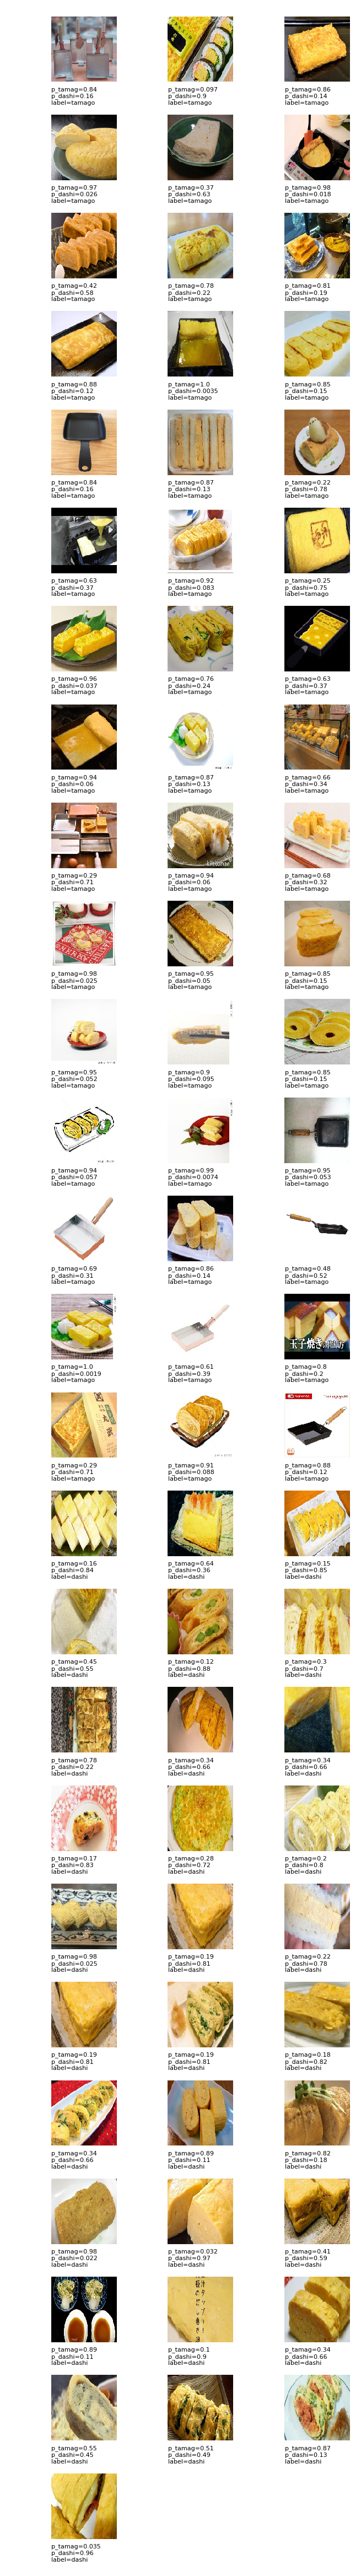

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

labels = y_test
imgs = test_set.get_full_data()
probs = lr_probs

n_cols = 3
nrows = len(labels) // n_cols
if len(labels) % n_cols:
    nrows+= 1
    
    
fig = plt.figure(figsize=(n_cols,nrows),dpi=200)

for i, (label, prob) in enumerate(zip(labels, probs)):
    plt.subplot(nrows, n_cols, i+1)
    plt.imshow(imgs[i])
    p_dashi = prob[0]
    p_tamag = prob[1]
    answer = {
        0: 'dashi',
        1: 'tamago'
    }[label]
    plt.text(0, 170,
             f"p_tamag={p_tamag:.2}\np_dashi={p_dashi:.2}\nlabel={answer}",
            fontsize=4)
    plt.axis('off')

plt.subplots_adjust(left=1, bottom=0, right=2, top=None, wspace=0.2, hspace=0.5)